In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [3]:
os.environ["NUMEXPR_NUM_THREADS"] = "16" # Apparently useless xd
os.environ["OPENBLAS_NUM_THREADS"] = "16"
os.environ["MKL_NUM_THREADS"] = "16"

In [4]:
beta = np.pi/2
gamma = np.pi/2
theta = 3 * np.pi/8
phi = np.pi/2

sqrt2 = np.sqrt(2)
im = complex(0.0,1.0)

In [5]:
interaction_pattern = "r"
cwd = os.getcwd()
n_qubits = 2
qubitstate_size = 2**n_qubits
max_dim = 1001
D = 101
# filename = "batch_instates/ordered_seed.txt"
# filename = "batch_instates/random_seed.txt"
filename = interaction_pattern+"seed_dim" + str(D) + "_q" + str(n_qubits) + ".txt"
seed = np.genfromtxt(cwd+"/data/seeds/"+filename, usecols = 0, delimiter=",", dtype = int)
# seed = np.genfromtxt("C:/dev/Multicqw/data/seeds/"+interaction_pattern+filename, usecols = 0, delimiter=",", dtype = int)
T = seed.size
dims = np.arange(3,max_dim,10)
dim_concurrences = []
dim_variances = []
start_skip = 1000

In [6]:
for D in dims:
    p = np.arange(0,D,1)
    w = 2*np.pi/D
    U = np.zeros((D,2,2),np.complex128)
    U[:,0,0] = np.exp(im*gamma) * np.cos(beta/2) * np.exp(-im*p)
    U[:,1,0] = -np.exp(im*gamma) * np.sin(beta/2) * np.exp(im*p)
    U[:,0,1] = np.sin(beta/2) * np.exp(-im*p)
    U[:,1,1] = np.cos(beta/2) * np.exp(im*p)
    U1 = np.zeros((D,2,2),np.complex128)
    U2 = np.zeros((D,2,2),np.complex128)

    instate = np.zeros((D,2,2),np.complex128)
    instate[0,0,0] = np.cos(theta) * np.cos(theta)
    instate[0,1,0] = np.cos(theta) * np.sin(theta) * np.exp(im*phi)
    instate[0,0,1] = np.cos(theta) * np.sin(theta) * np.exp(im*phi)
    instate[0,1,1] = np.sin(theta) * np.sin(theta) * np.exp(2*im*phi)
    pstate = np.zeros((D,2,2),np.complex128)
    finstate = np.zeros((D,2,2),np.complex128)
    transf = np.zeros((D,D),np.complex128)
    omegap = np.exp(im*w*p)
    for m in p:
        transf[m,:] = omegap**m
        U1[m,:,:] = np.identity(2)
        U2[m,:,:] = np.identity(2)
    np.multiply(1/np.sqrt(D),transf,out=transf);
    np.einsum('pq,qmn -> pmn',transf,instate,out=pstate);

    concurrences = np.zeros(T,float)
    j = 0
    for int_qubit in seed:
        if int_qubit:
            np.einsum('pjk,pkl->pjl',U2,U,out=U2)
        else:
            np.einsum('pjk,pkl->pjl',U1,U,out=U1)

        evop = np.einsum('pjk,pmn->pjkmn',U1,U2)
        np.einsum('pjkmn,pkn->pjm',evop,pstate,out=finstate)
        result = np.einsum('pq,pmn->qmn',np.conj(transf),finstate)
        concurrences[j] = np.sum(2*np.absolute(np.multiply(result[:,0,0],result[:,1,1]) - np.multiply(result[:,0,1],result[:,1,0])))
        j += 1
    dim_concurrences.append(np.average(concurrences[start_skip:]))
    dim_variances.append(np.var(concurrences[start_skip:]))

In [7]:
D = max_dim
p = np.arange(0,D,1)
w = 2*np.pi/D
U = np.zeros((D,2,2),np.complex128)
U[:,0,0] = np.exp(im*gamma) * np.cos(beta/2) * np.exp(-im*p)
U[:,1,0] = -np.exp(im*gamma) * np.sin(beta/2) * np.exp(im*p)
U[:,0,1] = np.sin(beta/2) * np.exp(-im*p)
U[:,1,1] = np.cos(beta/2) * np.exp(im*p)
U1 = np.zeros((D,2,2),np.complex128)
U2 = np.zeros((D,2,2),np.complex128)

instate = np.zeros((D,2,2),np.complex128)
instate[0,0,0] = np.cos(theta) * np.cos(theta)
instate[0,1,0] = np.cos(theta) * np.sin(theta) * np.exp(im*phi)
instate[0,0,1] = np.cos(theta) * np.sin(theta) * np.exp(im*phi)
instate[0,1,1] = np.sin(theta) * np.sin(theta) * np.exp(2*im*phi)
pstate = np.zeros((D,2,2),np.complex128)
finstate = np.zeros((D,2,2),np.complex128)
transf = np.zeros((D,D),np.complex128)
omegap = np.exp(im*w*p)
for m in p:
    transf[m,:] = omegap**m
    U1[m,:,:] = np.identity(2)
    U2[m,:,:] = np.identity(2)
np.multiply(1/np.sqrt(D),transf,out=transf);
np.einsum('pq,qmn -> pmn',transf,instate,out=pstate);

concurrences = np.zeros(T,float)
j = 0
for int_qubit in seed:
    if int_qubit:
        np.einsum('pjk,pkl->pjl',U2,U,out=U2)
    else:
        np.einsum('pjk,pkl->pjl',U1,U,out=U1)

    evop = np.einsum('pjk,pmn->pjkmn',U1,U2)
    np.einsum('pjkmn,pkn->pjm',evop,pstate,out=finstate)
    result = np.einsum('pq,pmn->qmn',np.conj(transf),finstate)
    concurrences[j] = np.sum(2*np.absolute(np.multiply(result[:,0,0],result[:,1,1]) - np.multiply(result[:,0,1],result[:,1,0])))
    j += 1
dim_concurrences.append(np.average(concurrences[start_skip:]))
dim_variances.append(np.var(concurrences[start_skip:]))

In [8]:
full_dims = np.append(dims,max_dim)

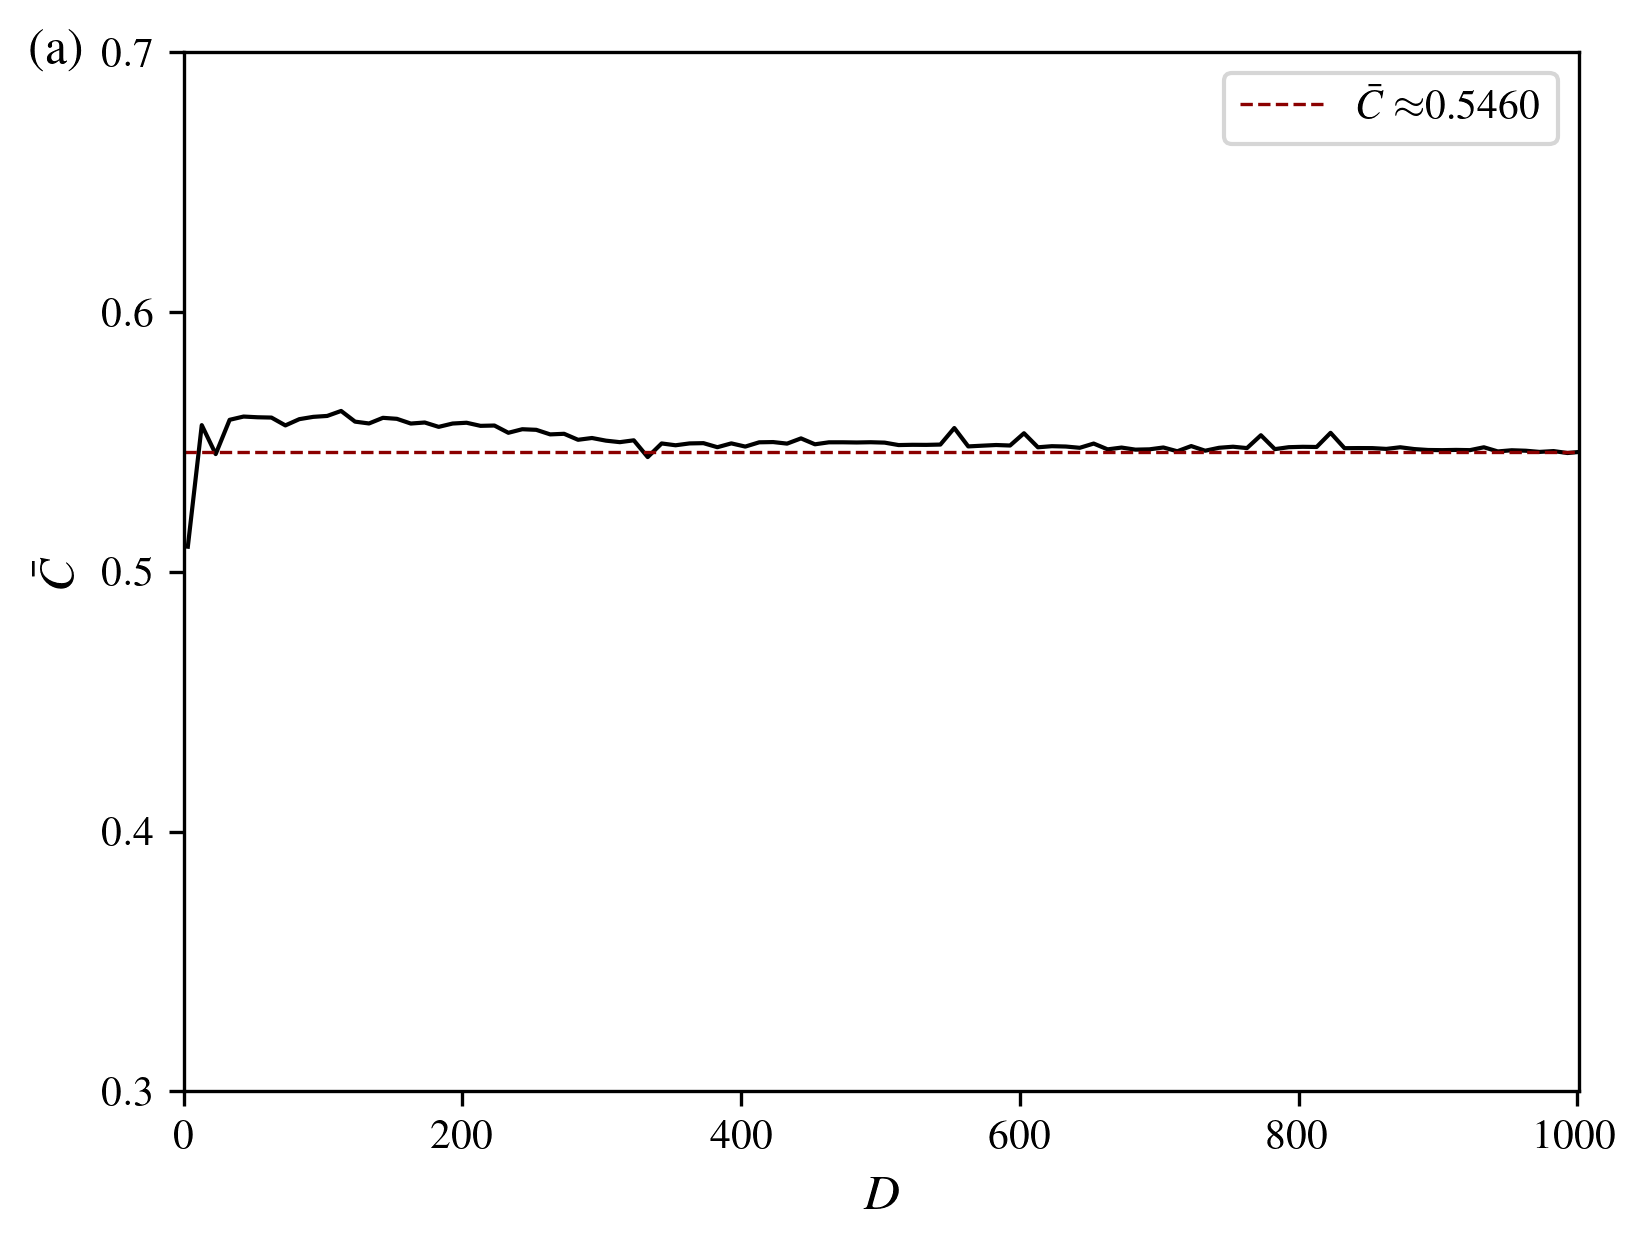

In [9]:
fig = plt.figure(figsize=(6,4.5),dpi=300)
ax = fig.subplots()
ax.plot(full_dims,dim_concurrences,'k',lw=1)
ax.plot((0,max_dim),(dim_concurrences[-1],dim_concurrences[-1]),'--', label = r'$\bar{C} \approx $' + str(dim_concurrences[-1])[:6],lw=0.8,color="darkred")
fig.text(0.055,0.88, '(a)', horizontalalignment='center', verticalalignment='center', fontsize=12)
xticks = np.arange(0,max_dim,200)
yticks = np.arange(0.3,0.71,0.1)
ax.set_xticks(xticks)
ax.set_xlim(0,max_dim)
ax.set_xlabel(r'$D$', fontsize=12)
ax.set_yticks(yticks)
ax.set_ylim(0.3,0.7)
ax.set_ylabel(r'$\bar{C}$', fontsize = 12)
ax.legend()

In [10]:
variances = np.array(dim_variances)

Text(0, 0.5, '$\\sigma/\\bar{C}$')

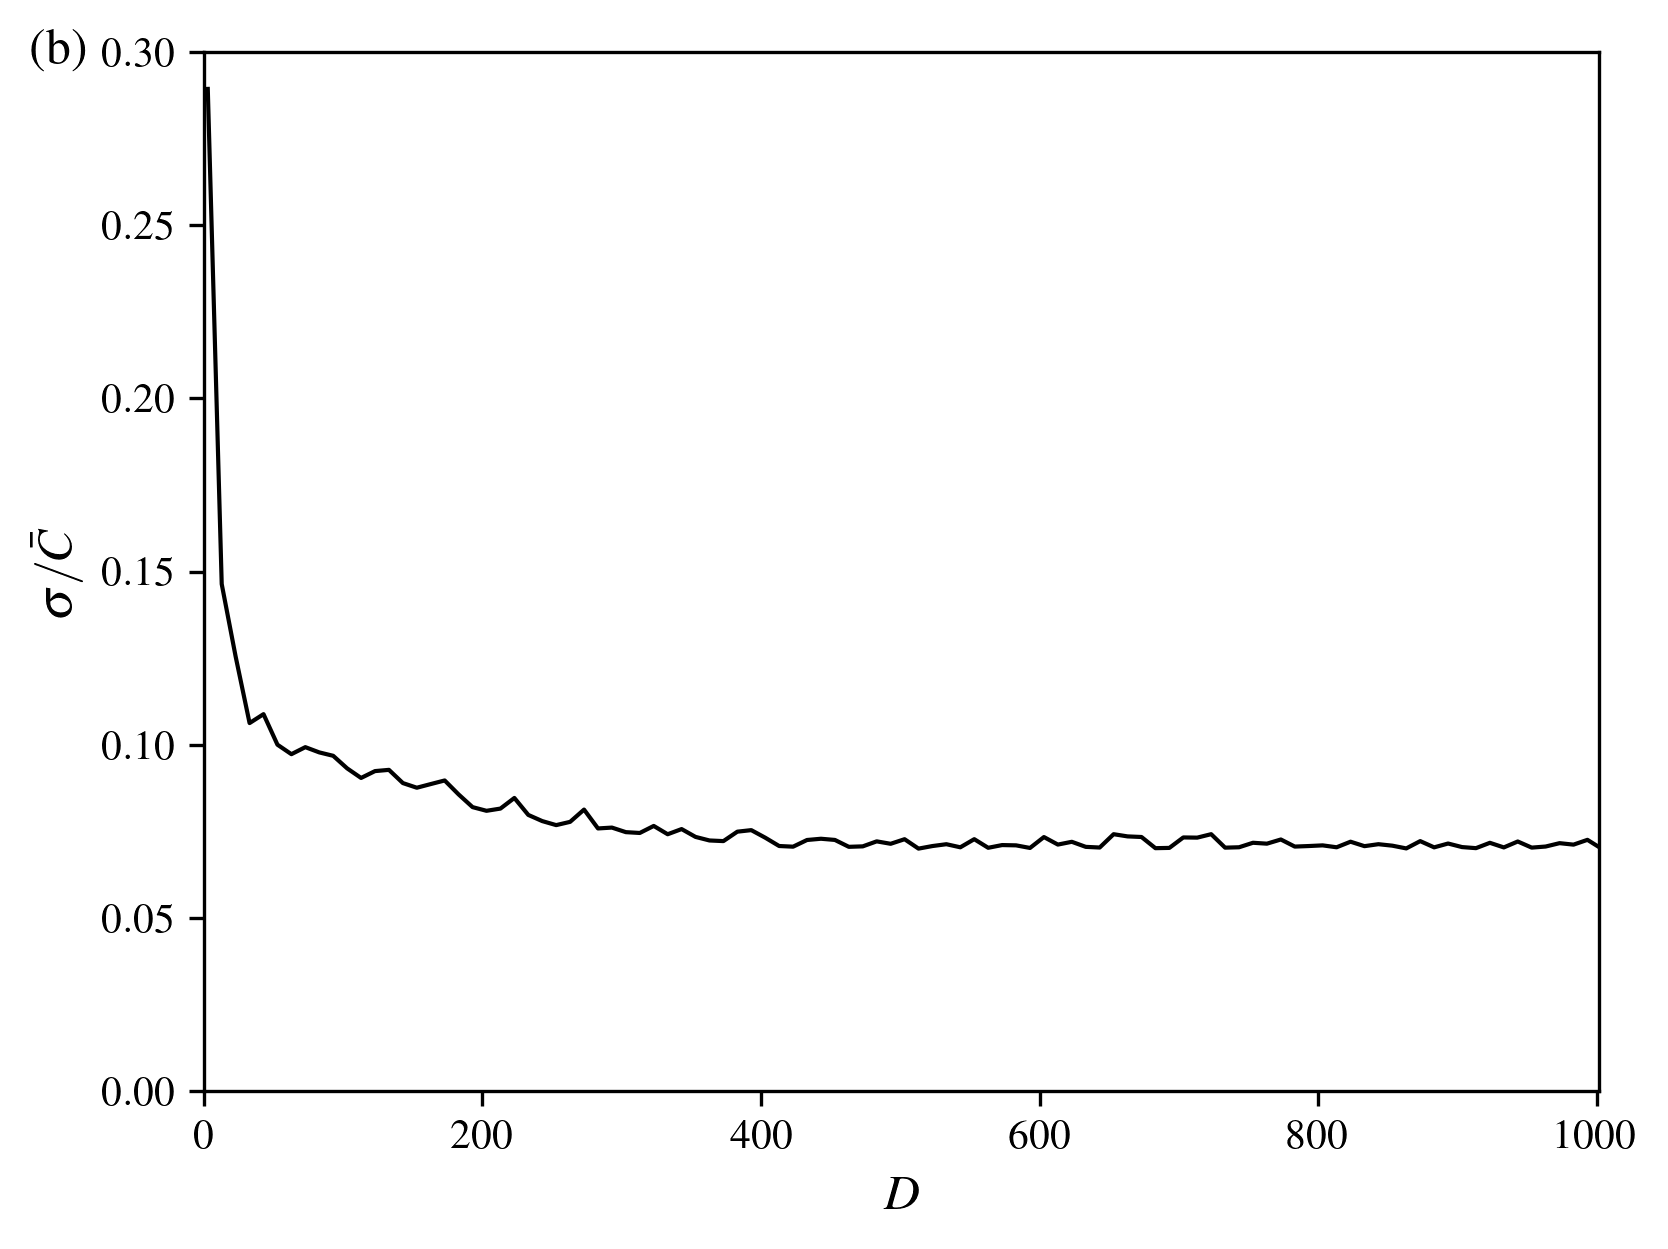

In [11]:
fig = plt.figure(figsize=(6,4.5),dpi=300)
ax = fig.subplots()
ax.plot(full_dims,np.sqrt(variances)/dim_concurrences,'k',lw=1)
fig.text(0.045,0.88, '(b)', horizontalalignment='center', verticalalignment='center', fontsize=12)
xticks = np.arange(0,max_dim,200)
ax.set_xticks(xticks)
ax.set_xlim(0,max_dim)
ax.set_xlabel(r'$D$', fontsize=12)
ax.set_ylim(0,0.3)
ax.set_ylabel(r'$\sigma/\bar{C}$', fontsize = 12)